<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Discontinuous Galerkin - Linear Elasticity 1D</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

* Kenneth Duru


In [1]:
import Lagrange
import numpy as np
import timeintegrate
import quadraturerules
import specdiff
import utils
import matplotlib.pyplot as plt

plt.switch_backend("nbagg")
plt.ion()



/Users/kduru/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/kduru/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


points per wavelength:  5


<IPython.core.display.Javascript object>


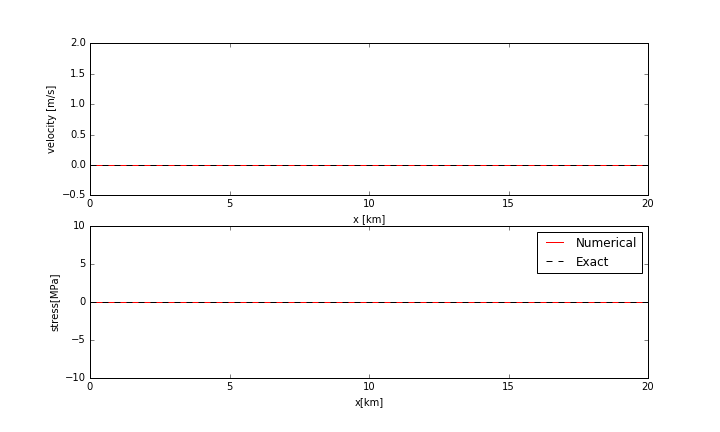

In [2]:
# tic
iplot  = 20

# physical domain x = [ax, bx] (km)
ax = 0.0       # (km)
bx = 20.0      # (km)

# choose quadrature rules and the corresponding nodes
# we use Gauss-Legendre-Lobatto (Lobatto) or  Gauss-Legendre (Legendre) quadrature rule.

node = 'Lobatto'
node = 'Legendre'

if node not in ('Lobatto', 'Legendre'):
     print('quadrature rule not implemented. choose node = Legendre or node = Lobatto')
     exit(-1)

# polynomial degree N: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
N = 5                  # Lagrange polynomial degree
NP = N+1                # quadrature nodes per element

if N < 1 or N > 12:
    print('polynomial degree not implemented. choose N>= 1 and N <= 12')
    exit(-1)


# degrees of freedom to resolve the wavefield    
deg_of_freedom = 500

# estimate the number of elements needed for a given polynomial degree and degrees of freedom
num_element = round(deg_of_freedom/NP)


# Initialize the mesh
y = np.zeros(NP*num_element)

# Generate num_element dG elements in the interval [ax, bx]
x0 = np.linspace(ax,bx,num_element+1)
dx = np.diff(x0)                        # element sizes


# Generate Gauss quadrature nodes (psi): [-1, 1] and weights (w)
if node == 'Legendre':
    GL_return = quadraturerules.GL(N)
    psi = GL_return['xi']
    w = GL_return['weights'];
    
if node == 'Lobatto':
    gll_return = quadraturerules.gll(N)
    psi = gll_return['xi']
    w = gll_return['weights']

# Use the Gauss quadrature nodes (psi) generate the mesh (y)
for i in range (1,num_element+1):
    for j in range (1,(N+2)):
        y[j+(N+1)*(i-1)-1] = dx[i-1]/2.0 * (psi[j-1] + 1.0) +x0[i-1]

# overide with the exact degrees of freedom        
deg_of_freedom = len(y);

# generate the spectral difference operator (D) in the reference element: [-1, 1]  
D = specdiff.derivative_GL(N, node)

# Boundary condition reflection coefficients 
r0 = 0.0        # r=0:absorbing, r=1:free-surface, r=-1: clamped, 
rn = 0.0        # r=0:absorbing, r=1:free-surface, r=-1: clamped, 

# Initialize the wave-fields
L = 0.5*(bx-ax)
delta = 0.01*(bx-ax)
x0 = 0.5*(bx+ax)

omega = 4.0
#u = np.sin(omega*np.pi*y/L);                                           # Sine function
u = 1/np.sqrt(2.0*np.pi*delta**2)*np.exp(-(y-x0)**2/(2.0*delta**2))     # Gaussian
    
u = np.transpose(u)
v = np.zeros(len(u))

U = np.zeros(len(u))
V = np.zeros(len(u))

print('points per wavelength: ', round(delta*deg_of_freedom/(2*L)))
    
# Initialize animated plot
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
line1 = ax1.plot(y, u, 'r', y, U, 'k--')
plt.xlabel('x [km]')
plt.ylabel('velocity [m/s]')

ax2 = fig.add_subplot(2,1,2)
line2 = ax2.plot(y, v, 'r', y, V, 'k--') 
plt.xlabel('x[km]')
plt.ylabel('stress[MPa]')
plt.ion()
plt.show()

# Material parameters
cs = 3.464              # shear wave speed (km/s)
rho =0*y+2.67              # density          (g/cm^3)
mu = 0*y+rho * cs**2        # shear modulus    (GPa)
Zs = rho*cs             # shear impedance    


# Time stepping parameters
cfl = 0.5                                # CFL number
dt = (cfl/(cs*(2*N+1)))*min(dx)         # time-step (s)
t = 0.0                                  # initial time
Tend = 5.0                               # final time (s)
n = 0                                    # counter

In [3]:
# Loop through time and evolve the wave-fields using ADER time-stepping scheme of N+1 order of accuracy
for t in utils.drange (0.0, Tend+dt,dt):
    n = n+1
    ADER_Wave_dG_return = timeintegrate.ADER_Wave_dG(u,v,D,NP,num_element,dx,w,psi,t,r0,rn,dt,rho,mu)
    u = ADER_Wave_dG_return['Hu']
    v = ADER_Wave_dG_return['Hv']

    # Analytical
    #U = 0.5*(np.sin(omega*np.pi/L*(y+cs*(t+1*dt))) + np.sin(omega*np.pi/L*(y-cs*(t+1*dt))))
    #V = 0.5*Zs*(np.sin(omega*np.pi/L*(y+cs*(t+1*dt))) - np.sin(omega*np.pi/L*(y-cs*(t+1*dt))))

    U =  1/np.sqrt(2.0*np.pi*delta**2)*0.5*(np.exp(-(y+cs*(t+1*dt)-x0)**2/(2.0*delta**2)) + np.exp(-(y-cs*(t+1*dt)-x0)**2/(2.0*delta**2)))
    V =  1/np.sqrt(2.0*np.pi*delta**2)*0.5*Zs*(np.exp(-(y+cs*(t+1*dt)-x0)**2/(2.0*delta**2)) - np.exp(-(y-cs*(t+1*dt)-x0)**2/(2.0*delta**2)))

    # plotting
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l 

        # Display lines
        line1 = ax1.plot(y, u, 'r', y, U, 'k--')
        line2 = ax2.plot(y, v, 'r', y, V, 'k--')
        plt.legend(iter(line2), ('Numerical', 'Exact'))
        plt.gcf().canvas.draw()
       
plt.ioff()
plt.show() 